**Graph Machine Learning with Keras and TigerGraph**

In this notebook, we will walk through a demonstration using Keras framework with the output of a graph to run a prediction of covid wave in India. The data is collected from a Our World in Data database. Using Pandas, we can transform that data into a dataframe. After transforming data, we get the data ready for a basic ML model with Keras framework. Forecasting Techniques are used that provides the knowledge of planning pandemic situation and can take appropriate actions in advance before actually they are put out of situation. Forecasting provides the knowledge about the nature of future conditions.

COVID-19 is a pandemic that has affected over 170 countries around the world. The number of infected and deceased patients has been increasing at an alarming rate in almost all the affected nations. **Forecasting techniques can be inculcated thereby assisting in designing better strategies and in taking productive decisions. These techniques assess the situations of the past thereby enabling better predictions about the situation to occur in the future.** These predictions might help to prepare against possible threats and consequences. Forecasting techniques play a very important role in yielding accurate predictions. This study categorizes forecasting techniques into two types, namely, stochastic theory mathematical models and data science/machine learning techniques. Forecasting of a pandemic(new cases and deaths) can be done based on various parameters.

Since the beginning of the COVID-19 epidemic, there has been several mathematical and statistical modelling that have predicted the global and national epidemic with varying degrees of accuracy and reliability. The accuracy of prediction and its uncertainty depend on the assumptions, availability and quality of data. The results can vary significantly if there is difference in the assumptions, and values of input parameters. During a pandemic like COVID-19, the availability and quality of data keep improving as the epidemic progress, which make predictions uncertain in the early stages and expected to improve in the later stages. Moreover, an epidemic may not always behave in the same manner as pathogens are likely to behave differently over time. These techniques and parameters used for forecasting are extensively studied in this notebook.

In [ ]:
import pandas as pd
import numpy as np
from numpy.random import seed
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
import math
import warnings
warnings.filterwarnings('ignore')
from datetime import timedelta
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from fbprophet import Prophet
import holidays

In [ ]:
data = pd.read_csv('../input/reuters/1 - Copy.csv',parse_dates=True,index_col='date')
data.head()

,location,total_cases,new_cases,total_deaths,new_deaths,total_tests,new_tests,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,new_cases_smoothed,new_deaths_smoothed
date,,,,,,,,,,,,,
2020-01-30,India,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-31,India,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-01,India,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-02,India,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-03,India,3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


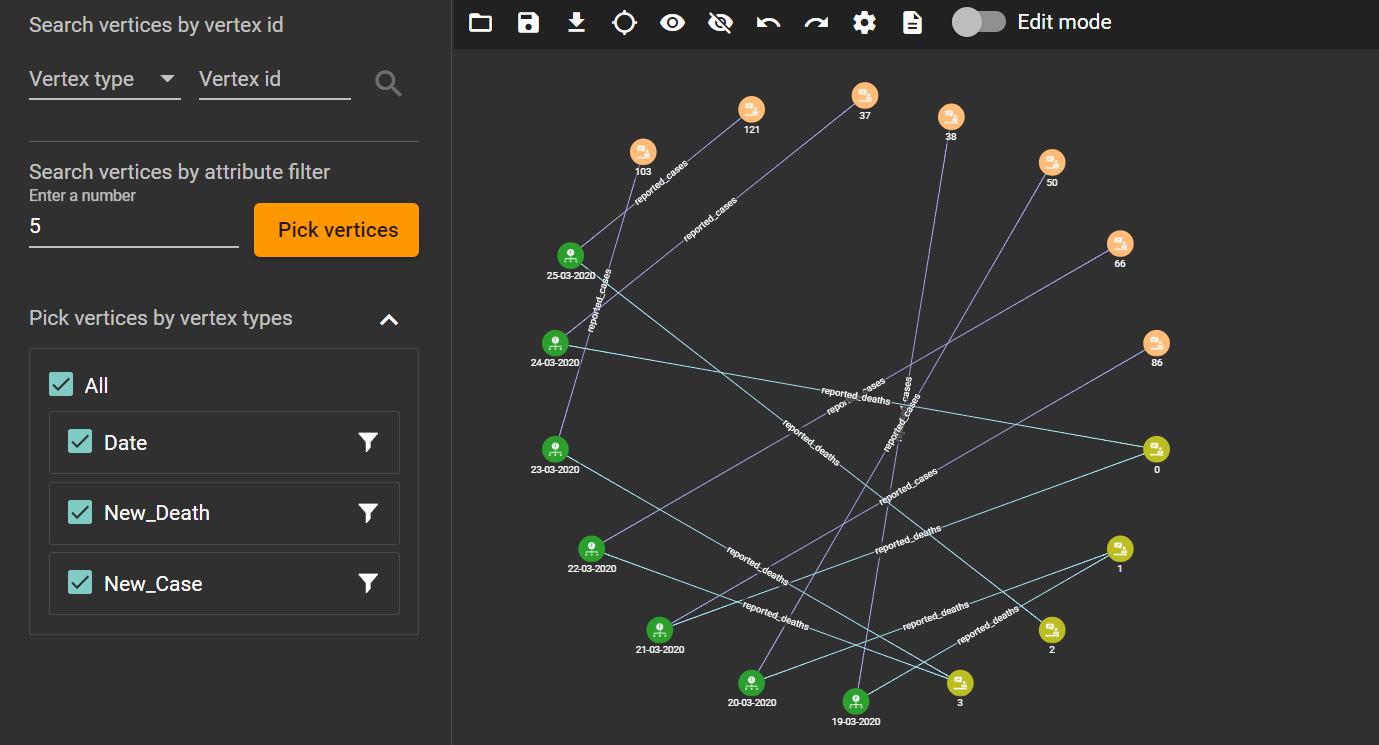

Fig: Few samples from the population

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 781 entries, 2020-01-30 to 2022-03-20
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   location                 781 non-null    object 
 1   total_cases              781 non-null    int64  
 2   new_cases                781 non-null    int64  
 3   total_deaths             740 non-null    float64
 4   new_deaths               738 non-null    float64
 5   total_tests              713 non-null    float64
 6   new_tests                700 non-null    float64
 7   total_vaccinations       417 non-null    float64
 8   people_vaccinated        417 non-null    float64
 9   people_fully_vaccinated  389 non-null    float64
 10  new_vaccinations         407 non-null    float64
 11  new_cases_smoothed       775 non-null    float64
 12  new_deaths_smoothed      720 non-null    float64
dtypes: float64(10), int64(2), object(1)
memory usage: 85.4+ KB


**Pipeline:**

Import all the required libraries -> Read the dataset -> get the data ready for a model -> scale the data -> Train a model with timestep data -> test it on test dataset -> make future prediction

In [ ]:
data['new_deaths'].fillna(0,inplace=True)

<Figure size 432x288 with 0 Axes>

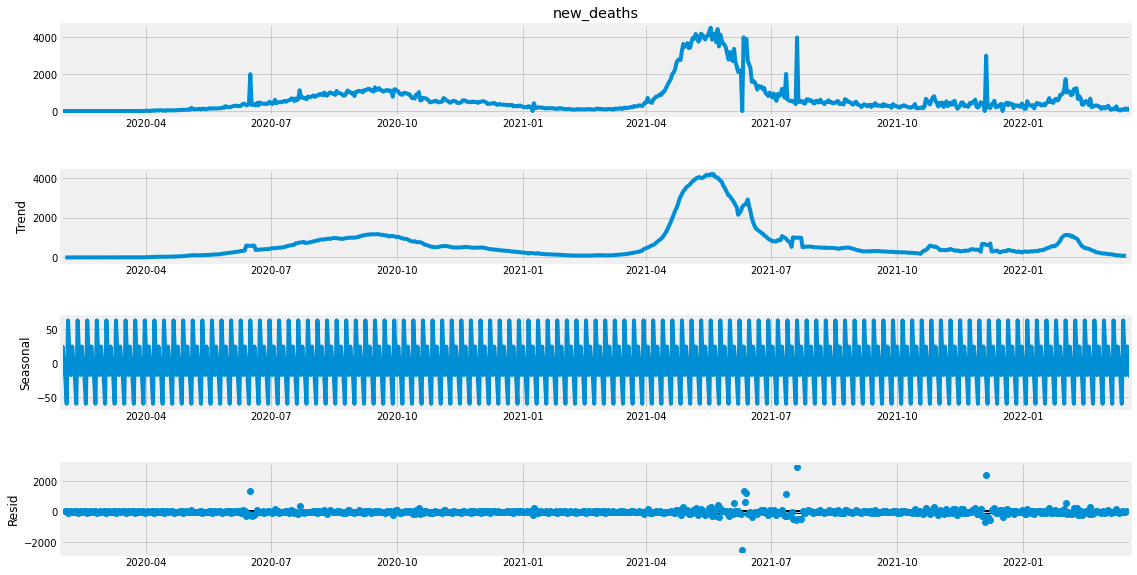

In [ ]:
result = seasonal_decompose(x=data['new_deaths'])
fig = plt.figure()
fig = result.plot()  
fig.set_size_inches(18, 9);

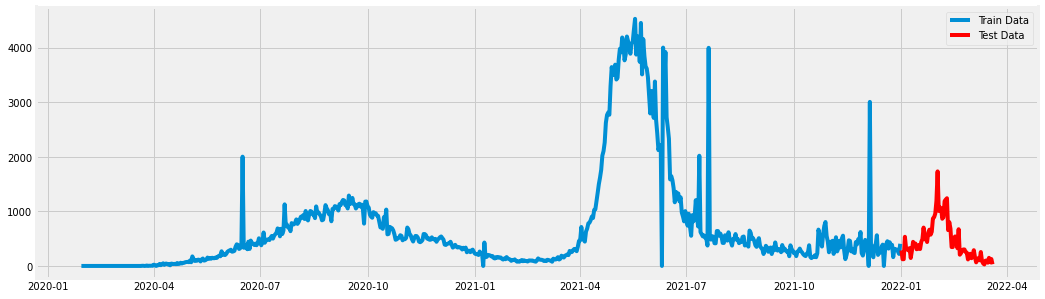

In [ ]:
train_data, test_data = data[0:int(len(data)*0.90)], data[int(len(data)*0.90):]
plt.figure(figsize=(16,5))
plt.plot(train_data.new_deaths,label='Train Data')
plt.plot(test_data.new_deaths,'red',label='Test Data')
plt.legend();

In [ ]:
train = train_data.iloc[:,4:5]

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)

In [ ]:
timesteps = 50
X_train = []
y_train = []
for i in range(timesteps, train.shape[0]):
    X_train.append(train_scaled[i-timesteps:i, 0]) 
    y_train.append(train_scaled[i, 0]) 
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape, y_train.shape

((652, 50), (652,))

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

***Long short-term memory(LSTM) Model***

In [ ]:
#Long short-term memory(LSTM) cells are used in recurrent neural networks that learn to predict the future from sequences of variable lengths.
model = Sequential()
#Adding the first LSTM layer 
#return_sequences=True means whether to return the last output in the output sequence. It basically tells us that there is another LSTM layer ahead in the network.
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
#Dropout regularisation for tackling overfitting
model.add(Dropout(0.20))
model.add(LSTM(units = 100, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50))
#Adding the output layer
model.add(Dense(units = 1))
#Compiling the model
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
#Fitting the modelRNN to the Training set
model.fit(X_train, y_train, epochs = 40, batch_size = 32)

2022-04-07 07:44:49.453801: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-04-07 07:44:50.856415: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/40
21/21 [==============================] - 12s 179ms/step - loss: 0.0271
Epoch 2/40
21/21 [==============================] - 4s 175ms/step - loss: 0.0110
Epoch 3/40
21/21 [==============================] - 4s 169ms/step - loss: 0.0076
Epoch 4/40
21/21 [==============================] - 4s 173ms/step - loss: 0.0080
Epoch 5/40
21/21 [==============================] - 4s 167ms/step - loss: 0.0063
Epoch 6/40
21/21 [==============================] - 4s 195ms/step - loss: 0.0060
Epoch 7/40
21/21 [==============================] - 4s 174ms/step - loss: 0.0070
Epoch 8/40
21/21 [==============================] - 4s 169ms/step - loss: 0.0060
Epoch 9/40
21/21 [==============================] - 4s 171ms/step - loss: 0.0055
Epoch 10/40
21/21 [==============================] - 4s 175ms/step - loss: 0.0064
Epoch 11/40
21/21 [==============================] - 4s 170ms/step - loss: 0.0055
Epoch 12/40
21/21 [==============================] - 4s 168ms/step - loss: 0.0055
Epoch 13/40
21/21 [=====

In [ ]:
#This will be used later while comparing and visualization
real_new_cases = test_data.iloc[:,4:5].values # taking open price

In [ ]:
combine = pd.concat((train_data['new_deaths'], test_data['new_deaths']), axis = 0)
test_inputs = combine[len(combine) - len(test_data) - timesteps:].values
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)

In [ ]:
X_test = []
for i in range(timesteps, test_data.shape[0]+timesteps):
    X_test.append(test_inputs[i-timesteps:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted = model.predict(X_test)
#inverse_transform because prediction is done on scaled inputs
predicted = scaler.inverse_transform(predicted)

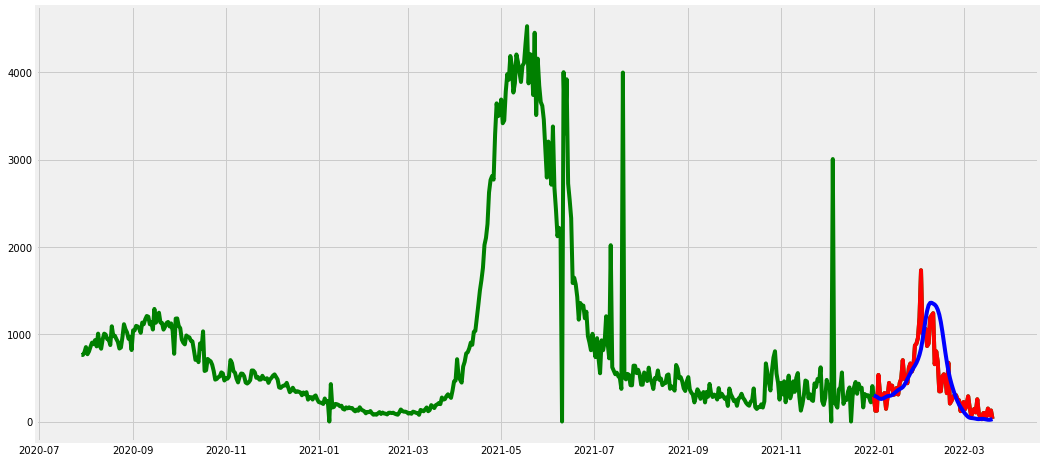

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(data.index[-600:], data['new_deaths'].tail(600), color='green', label = 'Train Data')
plt.plot(test_data.index, real_new_cases, color = 'red', label = 'New Cases')
plt.plot(test_data.index, predicted, color = 'blue', label = 'Predicted New Cases');

In [ ]:
mae = mean_absolute_error(real_new_cases, predicted)
print('MAE: '+str(mae))
mse = mean_squared_error(real_new_cases, predicted)
print('MSE: '+str(mse))
rmse = math.sqrt(mean_squared_error(real_new_cases, predicted))
print('RMSE: '+str(rmse))
mape = mean_absolute_percentage_error(real_new_cases, predicted)
print('MAPE: '+str(mape))
lstm_error = [mae,mse,rmse,mape]

MAE: 169.57305968562258
MSE: 68621.94735137741
RMSE: 261.95791141207667
MAPE: 0.47392269831992234


In [ ]:
#Future predictions in determining the direction of future trends
timestep = 45
def insert_end(Xin,new_input):
    for i in range(timestep-1):
        Xin[:,i,:] = Xin[:,i+1,:]
    Xin[:,timestep-1,:] = new_input
    return Xin

In [ ]:
future = 100
forcast = []
Xin = X_test[-1:]
for i in range(future):
    out = model.predict(Xin, batch_size=1)    
    forcast.append(out[0,0]) 
    Xin = insert_end(Xin,out[0,0]) 

In [ ]:
forcasted_output = np.asanyarray(forcast)   
forcasted_output = forcasted_output.reshape(-1,1) 
forcasted_output = scaler.inverse_transform(forcasted_output) 

forcasted_output = pd.DataFrame(forcasted_output)
date = pd.DataFrame(pd.date_range(start='2022-03-21',periods=100,freq='D'))
df_result = pd.concat([date,forcasted_output],axis=1)
df_result.columns = "Date","Forecasted"

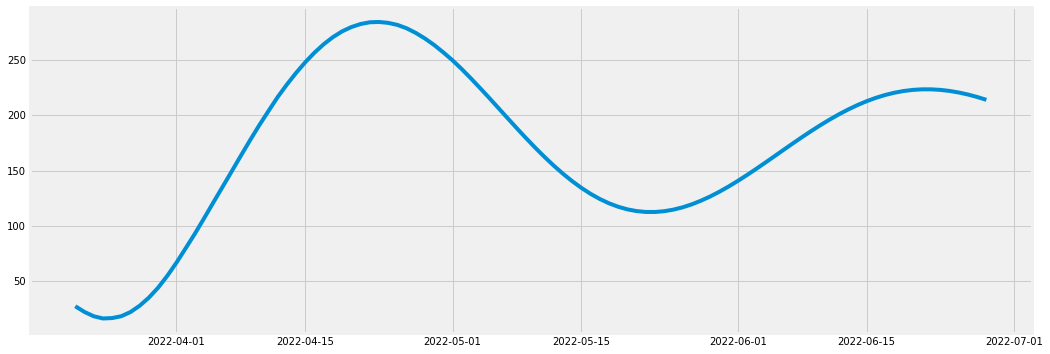

In [ ]:
plt.figure(figsize=(16,6))
plt.plot(df_result.set_index('Date')[['Forecasted']]);

***Prophet Model without Holiday Effects***

In [ ]:
data = pd.read_csv('../input/reuters/1 - Copy.csv',parse_dates=True)
data = data[['date','new_deaths']]
data['new_deaths'].fillna(0,inplace=True)
data = data.rename(columns={'date':'ds','new_deaths':'y'})
train, test = data[:-75], data[-75:]

In [ ]:
data.shape,train.shape,test.shape

((781, 2), (706, 2), (75, 2))

In [ ]:
#Prophet is a procedure for forecasting time series data based on additive model where non-linear trends are fit with yearly, weekly & daily, plus holiday effects.
prophet_model = Prophet(changepoint_prior_scale=0.5,n_changepoints=100,seasonality_mode='multiplicative',holidays_prior_scale=0.1)
#It works best with time series that have strong seasonal effects and several seasons of historical data.
prophet_model.fit(train) 

Initial log joint probability = -18.661


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1302.07    0.00606419       343.037           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1378.97     0.0275054       1206.56      0.3032      0.3032      266   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1457.85    0.00242216       157.593           1           1      387   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1496.33     0.0223632       201.185           1           1      517   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1510.87     0.0125885       449.156      0.2226           1      642   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599     

       alpha      alpha0  # evals  Notes 
    3299       1554.52   0.000706023       22.1739           1           1     4231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    3399       1555.77     0.0143293       36.5325      0.9497      0.9497     4359   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    3499       1556.42    0.00126868       15.0342      0.5566      0.5566     4482   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    3599       1556.85    0.00112039       43.4881           1           1     4615   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    3699       1557.03   8.68964e-05       35.6449      0.6555      0.6555     4745   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    3799       1557.11     0.0030215       21.6847           1 

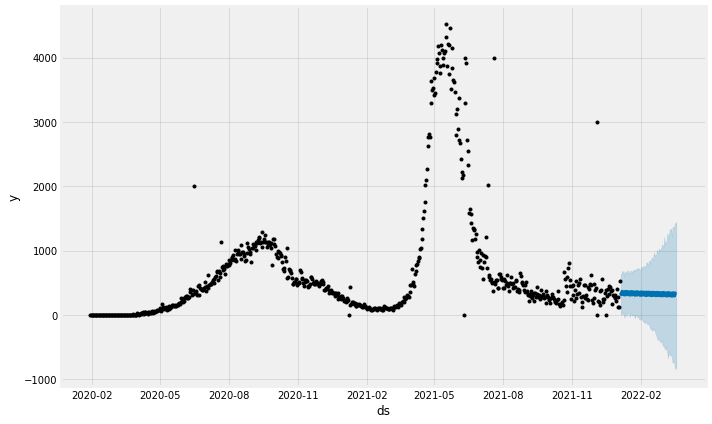

In [ ]:
test_forecast = prophet_model.predict(test)
prophet_model.plot(test_forecast);

In [ ]:
mae = mean_absolute_error(test['y'], test_forecast['yhat'])
print('MAE: '+str(mae))
mse = mean_squared_error(test['y'], test_forecast['yhat'])
print('MSE: '+str(mse))
rmse = math.sqrt(mean_squared_error(test['y'], test_forecast['yhat']))
print('RMSE: '+str(rmse))
mape = mean_absolute_percentage_error(test['y'], test_forecast['yhat'])
print('MAPE: '+str(mape))
prophet_withoutHolidays_error = [mae,mse,rmse,mape]

MAE: 261.97610167783927
MSE: 139513.99798139383
RMSE: 373.5157265516324
MAPE: 1.0654182071172469


In [ ]:
future = prophet_model.make_future_dataframe(periods=100, freq='D')
forecast_future = prophet_model.predict(future)
forecast_future[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
801,2022-04-10,310.807768,-1217.477187,1817.378804
802,2022-04-11,289.828716,-1178.280395,1695.410873
803,2022-04-12,327.288792,-1323.399113,2025.729983
804,2022-04-13,311.838033,-1336.054523,1903.376504
805,2022-04-14,292.661630,-1238.030948,1785.417730


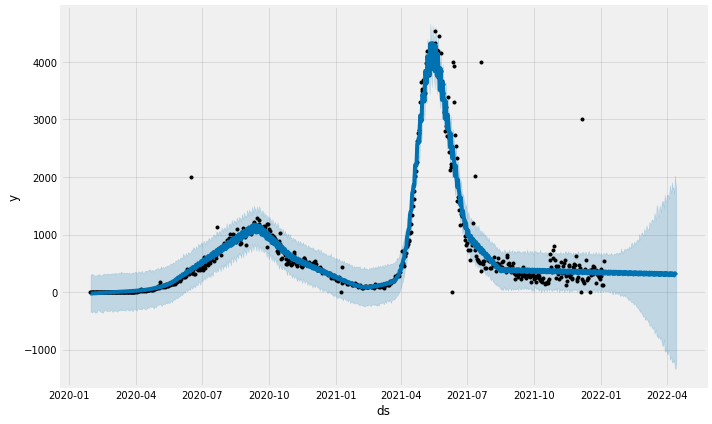

In [ ]:
prophet_model.plot(forecast_future);

***Prophet Model with Holiday Effects***

In [ ]:
#If you have holidays or other recurring events that you’d like to model, you must create a dataframe for them.
holiday = pd.DataFrame([])
#Holiday effects are included in the forecast by passing them in with the holidays argument.
for date, name in sorted(holidays.IND(years=[2020,2021,2022]).items()):
    holiday = holiday.append(pd.DataFrame({'ds': date, 'holiday': "IN-Holidays"}, index=[0]), ignore_index=True)
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

In [ ]:
#Prophet allows you to make forecasts using a logistic growth trend model, with a specified carrying capacity.
final_model = Prophet(holidays=holiday,
                      changepoint_prior_scale= 0.5,
                      holidays_prior_scale = 0.1,
                      n_changepoints = 150,
                      seasonality_mode = 'multiplicative',
                      weekly_seasonality=True,
                      daily_seasonality = True,
                      yearly_seasonality = True,
                      interval_width=0.8)
final_model.add_country_holidays(country_name='IND')
final_model.fit(train)

Initial log joint probability = -18.661


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1652.33   0.000893023       137.502      0.3406           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1669.04    0.00394258       595.424      0.2707           1      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1676.6   0.000837444       199.978      0.5632     0.05632      372   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1681.47    0.00365035       92.5131           1           1      493   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1685.21    0.00466832       161.227           1           1      615   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599     

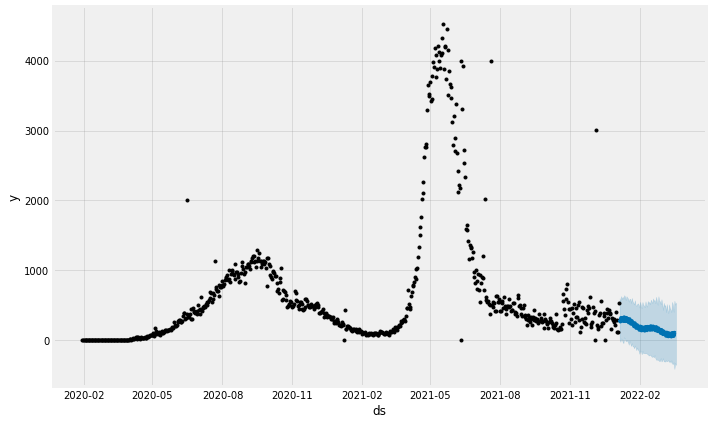

In [ ]:
test_forecast = final_model.predict(test)
final_model.plot(test_forecast);

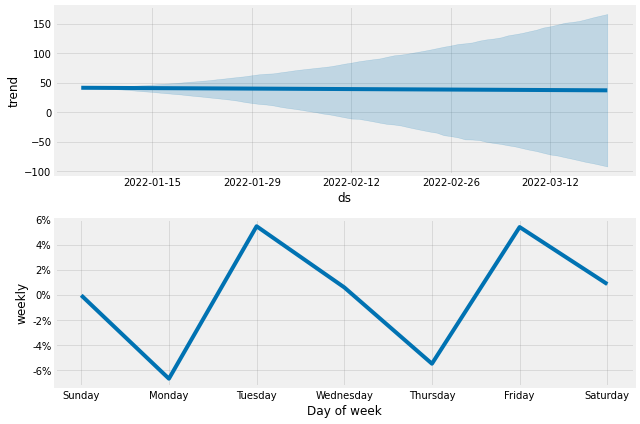

In [ ]:
prophet_model.plot_components(test_forecast);

In [ ]:
mae = mean_absolute_error(test['y'], test_forecast['yhat'])
print('MAE: '+str(mae))
mse = mean_squared_error(test['y'], test_forecast['yhat'])
print('MSE: '+str(mse))
rmse = math.sqrt(mean_squared_error(test['y'], test_forecast['yhat']))
print('RMSE: '+str(rmse))
mape = mean_absolute_percentage_error(test['y'], test_forecast['yhat'])
print('MAPE: '+str(mape))
prophet_withHolidays_error = [mae,mse,rmse,mape]

MAE: 285.8279190046504
MSE: 194419.66727836698
RMSE: 440.93045628349034
MAPE: 0.532680792043934


In [ ]:
future = final_model.make_future_dataframe(periods=200, freq='D')
forecast_future = final_model.predict(future)
forecast_future[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
901,2022-07-19,235.802358,-3811.371145,4478.290642
902,2022-07-20,222.149056,-3697.343668,4336.954208
903,2022-07-21,205.612849,-3447.652060,4034.741818
904,2022-07-22,243.979850,-4063.231232,4722.818963
905,2022-07-23,233.310827,-3891.005394,4608.556642


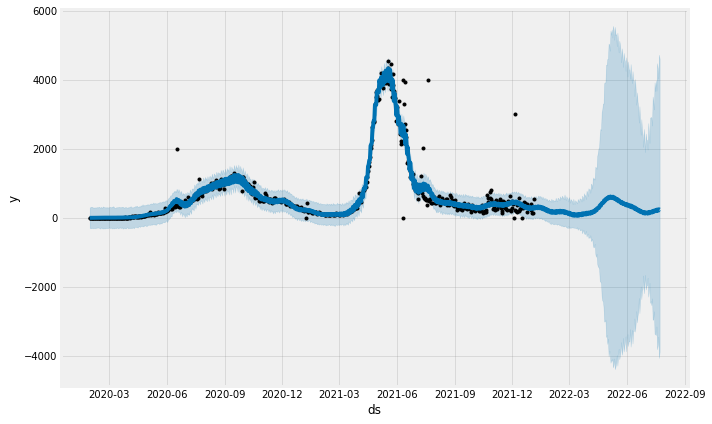

In [ ]:
final_model.plot(forecast_future);

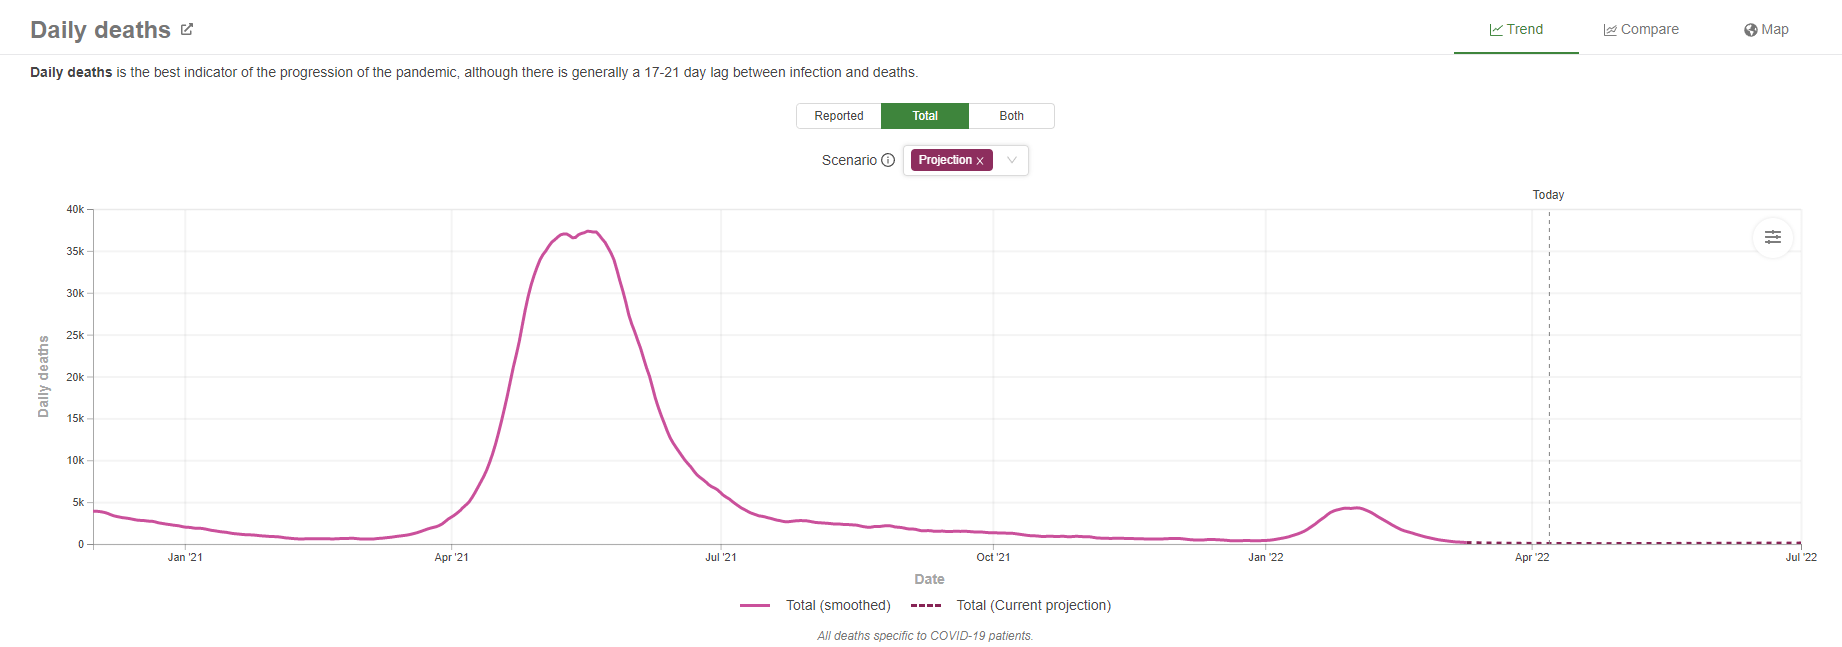

* We have compared our model with IHME forecasting model (https://covid19.healthdata.org/india)
* The comparison shows that our model is able to detect the trend in the data.
* IHME forcasting reported around 75-150 new deaths cases for the next few months where my model is saying 100-240 new death cases.
* We didn't see any sudden peak in new cases and deaths over the next few months.

Dataframe presents the goodness of fit statistics such as mean_absolute_error, mean_squared_error, root mean_squared_error and mean_absolute_percentage_error  for India. Statistic suggesting that LSTM could be the best model. There is scope for improvement.

In [ ]:
#Error Matrix
pd.DataFrame(data=[lstm_error,prophet_withoutHolidays_error,prophet_withHolidays_error],columns=['MAE','MSE','RMSE','MAPE'],
            index=['LSTM','Prophet Without Holidays','Prophet With Holidays'])

,MAE,MSE,RMSE,MAPE
LSTM,169.573060,68621.947351,261.957911,0.473923
Prophet Without Holidays,261.976102,139513.997981,373.515727,1.065418
Prophet With Holidays,285.827919,194419.667278,440.930456,0.532681


* The short term projection predicts exactly well with the observed number of new death cases in India. The findings from Prophet model may be used for planning the interventions and prepare the health systems for better clinical management of the infected in the country.
* As in any other projection using models, the limitation is that each model would behave differently, not merely due to differences in underlying assumptions.
* In Covid-19, there has been a higher level of uncertainly about the number of reported cases due to the issues in varying testing strategies, the proportion of asymptomatic cases and the effective transmission rate. Because of this, we may be missing a significant number of reported/confirmed cases which may affect the accuracy of any models.